In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from pandas import read_csv

import data

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
torch.manual_seed(441)

In [3]:
class Data(torch.utils.data.Dataset):
    def __init__(self, n=300):
        super().__init__()

        # X_train_data = read_csv('../X_train_nostring.csv')
        # X_train_data.fillna(-3, inplace=True)

        # self.X_train = X_train_data.values[:,1:]

        y_train_data = read_csv('../y_train.csv')
        self.y_train = y_train_data.values[:,1]
        for i in range(len(self.y_train)):
            if self.y_train[i] == -1:
                self.y_train[i] = 0

        self.ds = data.Dataset()
        self.X_train = self.ds.getTrain().values
        

        
    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.X_train[idx], dtype=torch.float32)
        y = self.y_train[idx]
        return x, y
    
    # def inputs(self):
    #     return torch.tensor(self.np_ds.inputs(), dtype=torch.float32)
    
    # def targets(self):
    #     return torch.tensor(self.np_ds.targets(), dtype=torch.float32)
    
    # def classes(self):
    #     return torch.tensor(self.np_ds.classes().squeeze(), dtype=torch.int)
    
    # def plot(self, labels=None, *args, **kwargs):
    #     if labels is not None:
    #         self.np_ds.plot(labels=labels.detach().numpy(), *args, **kwargs)
    #     else:
    #         self.np_ds.plot(labels=labels, *args, **kwargs)

In [4]:
ds = Data()
ds.X_train.shape

(48000, 1180)

In [5]:
# Batched, for training
batch_size_train = 250
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)

In [6]:
net = nn.Sequential(
    nn.BatchNorm1d(1180),
    nn.Linear(1180, 256),
    # nn.BatchNorm1d(512),
    # nn.ReLU(),
    # nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 5),
    nn.LogSoftmax(dim=1)
)

net.to(device)

Sequential(
  (0): BatchNorm1d(1180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=1180, out_features=256, bias=True)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=5, bias=True)
  (8): LogSoftmax(dim=1)
)

In [7]:
# Train it
loss_fcn = nn.NLLLoss(reduction='mean')
optim = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

def train(net, dl, epochs=100):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for data in dl:
            x, t = data
            y = net(x.to(device))

            loss = loss_fcn(y, t.to(device))
            epoch_loss += loss.item()
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        epoch_loss /= len(dl)
        losses.append(epoch_loss)
    
    plt.figure(figsize=(4,4))
    plt.plot(losses);
    
    return losses[-1]


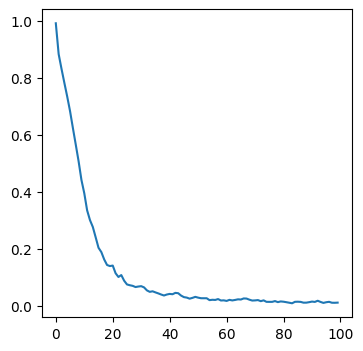

In [8]:
last = train(net, train_dl, 100)

In [9]:
print(last)

0.012508214139719106


around 1 for softmax and CrossEntropyLoss
around 0.0125 for logsoftmax and NLLLoss



In [11]:
X_test = ds.ds.getTest().values

prob = np.exp( net( torch.tensor(X_test, dtype=torch.float).to(device) ).cpu().detach().numpy() )

In [12]:
test = np.c_[ np.ones(11438), prob ]              # add a column

for i in range(len(test)):
    test[i][0] = i

np.savetxt('neural_net.csv', test, delimiter=',', header="id,no answer,very important,quite important,not important,not at all important", comments="", fmt='%1.4f') 